In [1]:
import os
import sys
sys.path.insert(0,'../')
from libs.ssl_data import *
from libs.ssl_model import *
from libs.ssl_utils import *
from libs.ssl_task import *
import lightning as L
from lightning.pytorch.tuner import Tuner
from lightning.pytorch import Trainer, seed_everything

%load_ext autoreload
%autoreload 2

In [2]:
seed_everything(3, workers=True)

Seed set to 3


3

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.


Using datasets: ['ds005509', 'ds005508', 'ds005507', 'ds005505', 'ds005506', 'ds005515', 'ds005516', 'ds005510', 'ds005511', 'ds005512', 'ds005514']


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:575: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_dfs)
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Using SimCLRSampler sampler with shuffle False
Number of datasets: 2589
Number of examples: 529106


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 2.2908676527677725e-05
Restoring states from the checkpoint path at /home/dung/eeg-ssl/notebooks/.lr_find_1a78509f-f0a5-4e37-ba5c-6e77e95af1fa.ckpt
Restored all states from the checkpoint at /home/dung/eeg-ssl/notebooks/.lr_find_1a78509f-f0a5-4e37-ba5c-6e77e95af1fa.ckpt


{'lr': [1e-08, 1.4454397707459274e-08, 1.7378008287493753e-08, 2.0892961308540398e-08, 2.51188643150958e-08, 3.019951720402016e-08, 3.630780547701014e-08, 4.36515832240166e-08, 5.248074602497726e-08, 6.309573444801934e-08, 7.585775750291837e-08, 9.120108393559096e-08, 1.0964781961431852e-07, 1.3182567385564074e-07, 1.5848931924611133e-07, 1.9054607179632475e-07, 2.2908676527677735e-07, 2.7542287033381663e-07, 3.311311214825911e-07, 3.9810717055349735e-07, 4.786300923226383e-07, 5.75439937337157e-07, 6.918309709189366e-07, 8.317637711026709e-07, 1e-06, 1.2022644346174132e-06, 1.445439770745928e-06, 1.7378008287493761e-06, 2.089296130854039e-06, 2.5118864315095797e-06, 3.0199517204020163e-06, 3.630780547701014e-06, 4.365158322401661e-06, 5.248074602497728e-06, 6.3095734448019305e-06, 7.585775750291836e-06, 9.120108393559096e-06, 1.0964781961431852e-05, 1.3182567385564076e-05, 1.584893192461114e-05, 1.9054607179632464e-05, 2.2908676527677725e-05, 2.7542287033381663e-05, 3.311311214825911e

2.2908676527677725e-05

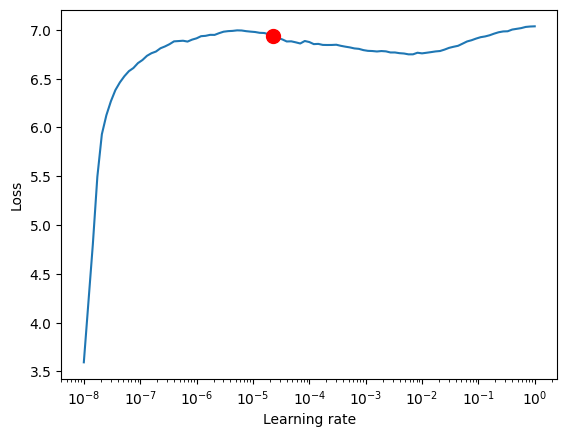

In [6]:
model = SimCLR.SimCLRLit(
        encoder_path='braindecode.models.Deep4Net', 
        encoder_kwargs={
                'n_outputs': 1024, 
                'n_chans': 129,
                'n_times': 500,
        },
        emb_size=128,
        encoder_emb_size=1024
)
trainer = L.Trainer()
tuner = Tuner(trainer)
datasets = ['ds005509','ds005508','ds005507','ds005505', 'ds005506', 'ds005515', 'ds005516', 'ds005510', 'ds005511', 'ds005512', 'ds005514']
data = SSLHBNDataModule(ssl_task=SimCLR(tau_pos_s=10), datasets=datasets, window_len_s=2, cache_dir='data')
# Run learning rate finder
lr_finder = tuner.lr_find(model, datamodule=data)

# Results can be found in
print(lr_finder.results)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
new_lr
# # update hparams of the model
# model.hparams.lr = new_lr

# # Fit model
# trainer.fit(model,data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Layer (type (var_name):depth-idx)             Input Shape               Output Shape              Param #                   Kernel Shape
Deep4Net (Deep4Net)                           [1, 129, 500]             [1, 1]                    --                        --
├─Ensure4d (ensuredims): 1-1                  [1, 129, 500]             [1, 129, 500, 1]          --                        --
├─Rearrange (dimshuffle): 1-2                 [1, 129, 500, 1]          [1, 1, 500, 129]          --                        --
├─CombinedConv (conv_time_spat): 1-3          [1, 1, 500, 129]          [1, 25, 491, 1]           80,900                    --
├─BatchNorm2d (bnorm): 1-4                    [1, 25, 491, 1]           [1, 25, 491, 1]           50                        --
├─ELU (conv_nonlin): 1-5                      [1, 25, 491, 1]           [1, 25, 491, 1]           --                        --
├─MaxPool2d (pool): 1-6                       [1, 25, 491, 1]           [1, 25, 163, 1]           -- 

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of datasets: 2589
Number of examples: 529106


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.008317637711026709
Restoring states from the checkpoint path at /home/dung/eeg-ssl/notebooks/.lr_find_e028b8ec-35cf-49d2-ba6a-4903f9bade38.ckpt
Restored all states from the checkpoint at /home/dung/eeg-ssl/notebooks/.lr_find_e028b8ec-35cf-49d2-ba6a-4903f9bade38.ckpt


{'lr': [1e-08, 1.4454397707459274e-08, 1.7378008287493753e-08, 2.0892961308540398e-08, 2.51188643150958e-08, 3.019951720402016e-08, 3.630780547701014e-08, 4.36515832240166e-08, 5.248074602497726e-08, 6.309573444801934e-08, 7.585775750291837e-08, 9.120108393559096e-08, 1.0964781961431852e-07, 1.3182567385564074e-07, 1.5848931924611133e-07, 1.9054607179632475e-07, 2.2908676527677735e-07, 2.7542287033381663e-07, 3.311311214825911e-07, 3.9810717055349735e-07, 4.786300923226383e-07, 5.75439937337157e-07, 6.918309709189366e-07, 8.317637711026709e-07, 1e-06, 1.2022644346174132e-06, 1.445439770745928e-06, 1.7378008287493761e-06, 2.089296130854039e-06, 2.5118864315095797e-06, 3.0199517204020163e-06, 3.630780547701014e-06, 4.365158322401661e-06, 5.248074602497728e-06, 6.3095734448019305e-06, 7.585775750291836e-06, 9.120108393559096e-06, 1.0964781961431852e-05, 1.3182567385564076e-05, 1.584893192461114e-05, 1.9054607179632464e-05, 2.2908676527677725e-05, 2.7542287033381663e-05, 3.311311214825911e

0.008317637711026709

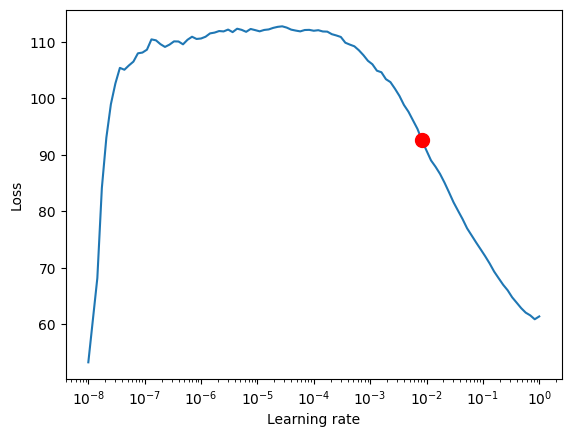

In [ ]:
model = Regression.RegressionLit(encoder_path='braindecode.models.Deep4Net', encoder_kwargs={
        'n_outputs': 1, 
        'n_chans': 129,
        'n_times': 500,
})
trainer = L.Trainer()
tuner = Tuner(trainer)
ssl_task = RelativePositioning(
    tau_pos_s=100,
    n_samples_per_dataset=100,
    same_rec_neg=False
)
data = SSLHBNDataModule(ssl_task=ssl_task, datasets=datasets, window_len_s=2, cache_dir='data')
# Run learning rate finder
lr_finder = tuner.lr_find(model, datamodule=data)

# Results can be found in
print(lr_finder.results)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
new_lr
# # update hparams of the model
# model.hparams.lr = new_lr

# # Fit model
# trainer.fit(model,data)